In [1]:
import urllib
from IPython.display import Markdown as md
_nb_loc = "03_image_models/03b_finetune_MOBILENETV2_flowers5.ipynb"
_nb_title = "5 flowers에 대해 MobileNetV2 파인 튜닝(이미지 분류)"
_nb_message = "이 노트북은 TPU 또는 GPU로 실행하도록 설정되어 있으며, TPUv3에서 실행했다. TPUv2(Colab)나 GPU 등 메모리가 적은 하드웨어에서 실행할 경우, [구성] 섹션에서 배치 크기나 이미지 크기를 작게 설정해야 할 수도 있다."
### no need to change any of this
_icons=["https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/ychoi-kr/practical-ml-vision-book-ko/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Google Colab에서 실행</a></td><td><a target="_blank" href="{2}"><img src="{6}" />GitHub에서 소스 보기</a></td><td><a href="{3}"><img src="{7}" />노트북 내려받기</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=5+flowers%EC%97%90+%EB%8C%80%ED%95%B4+MobileNetV2+%ED%8C%8C%EC%9D%B8+%ED%8A%9C%EB%8B%9D%28%EC%9D%B4%EB%AF%B8%EC%A7%80+%EB%B6%84%EB%A5%98%29&download_url=https%3A%2F%2Fgithub.com%2Fychoi-kr%2Fpractical-ml-vision-book-ko%2Fraw%2Fmaster%2F03_image_models%2F03b_finetune_MOBILENETV2_flowers5.ipynb"><img src="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/03_image_models/03b_finetune_MOBILENETV2_flowers5.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Google Colab에서 실행</a></td><td><a target="_blank" href="https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/03_image_models/03b_finetune_MOBILENETV2_flowers5.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub에서 소스 보기</a></td><td><a href="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/03_image_models/03b_finetune_MOBILENETV2_flowers5.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />노트북 내려받기</a></td></table><br/><br/><h1>5 flowers에 대해 MobileNetV2 파인 튜닝(이미지 분류)</h1>이 노트북은 TPU 또는 GPU로 실행하도록 설정되어 있으며, TPUv3에서 실행했다. TPUv2(Colab)나 GPU 등 메모리가 적은 하드웨어에서 실행할 경우, [구성] 섹션에서 배치 크기나 이미지 크기를 작게 설정해야 할 수도 있다.

In [2]:
# (옮긴이가 주석 처리리)
#!pip install --user --quiet --force keras-adamw

In [3]:
# (옮긴이가 주석 처리)
# adamw 패키지를 선택하기 위해 커널을 재시작
#import IPython

#IPython.Application.instance().kernel.do_shutdown(True)  # 자동으로 커널을 재시작

In [4]:
import math, re, os, sys
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tensorflow version 2.11.0


In [5]:
# (옮긴이가 주석 처리)

# 경고! 이 호출은 *모든* TensorFlow 호출 전에 와야 한다.
# AdamW를 찾을 수 없다는 오류가 발생하면 커널을 다시 시작하고 이전 셀에서 시작하라.
# os.environ['TF_KERAS'] = '1'  # AdamW
# from keras_adamw import AdamW


# TPU 또는 GPU 감지

In [6]:
try: # TPU를 감지
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:  # GPU들 또는 여러 대의 GPU 머신을 감지
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# 구성

Learning rate schedule: 1e-05 to 0.0001 to 2.21e-05


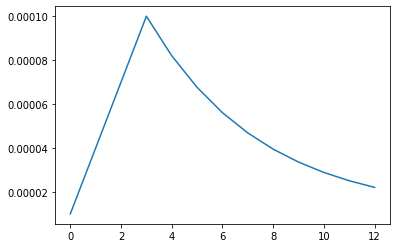

In [7]:
GCS_DS_PATH = "gs://practical-ml-vision-book/flowers_5_tfr"

# TPUv3에 대한 설정. TPUv2(Colab) 또는 GPU와 같이 메모리가 적은 하드웨어에서
# 실행하는 경우 더 낮은 BATCH_SIZE 및 IMAGE_SIZE 값을 사용해야 할 수 있다.

IMAGE_SIZE = [224, 224]  # flowers104 데이터셋에서 사용 가능한 이미지 크기: 512x512, 331x331, 224x224, 192x192
EPOCHS = 13

# 파인 튜닝을 위한 학습률 스케줄: trainable=True 사용(최고 검증 정확도 0.91)
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync
#LR_START = 0.00001
#LR_MAX = 0.000025 * strategy.num_replicas_in_sync
#LR_MIN = 0.00001
#LR_RAMPUP_EPOCHS = 3
#LR_SUSTAIN_EPOCHS = 1
#LR_EXP_DECAY = .8

# AdamW를 사용한 파인 튜닝을 위한 학습률 스케줄: trainable=True 사용(최고 검증 정확도 0.92)
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

# 전이 학습을 위한 학습률 스케줄: trainable=False 사용(최고 검증 정확도 0.90)
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync
#LR_START = 0.00001
#LR_MAX = 0.00075 * strategy.num_replicas_in_sync #(참고: 책의 그래프를 복제하려면 0.00007과 trainable=True로 설정)
#LR_MIN = 0.00001
#LR_RAMPUP_EPOCHS = 0
#LR_SUSTAIN_EPOCHS = 0
#LR_EXP_DECAY = .8

GCS_PATH_SELECT = {  # 사용 가능한 이미지 크기
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]] + '/*.tfrec'
filenames = tf.io.gfile.glob(GCS_PATH)
validation_split = 0.19
split = len(filenames) - int(len(filenames) * validation_split)
TRAINING_FILENAMES = filenames[:split]
VALIDATION_FILENAMES = filenames[split:]

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## 시각화 유틸리티
데이터 -> 픽셀, 이 섹션에는 머신러닝 실무자가 관심 가질 만한 내용이 없다.

In [8]:
# numpy와 matplotlib 기본값
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object:  # 이 경우 이진 문자열. 이것들은 이미지 ID 문자열임
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # 레이블이 없고 이미지 ID만 있는 경우, 레이블에 대해 None을 반환(테스트 데이터의 경우)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # 데이터터
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # 정사각형 또는 정사각형에 가까운 직사각형에 맞지 않는 데이터를 삭제
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # 크기와 간격
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # 디스플레이
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3  # 1x1에서 10x10 사이의 이미지에 잘 맞는 마법 공식
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    # 레이아웃
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    #plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES)
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #titlestring = ""
    #if score is not None:
    #    titlestring += 'f1 = {:.3f} '.format(score)
    #if precision is not None:
    #    titlestring += '\nprecision = {:.3f} '.format(precision)
    #if recall is not None:
    #    titlestring += '\nrecall = {:.3f} '.format(recall)
    #if len(titlestring) > 0:
    #    ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    # zoom_pcent: X는 데이터 포인트의 마지막 X%에 대해 y축을 자동 조정
    if subplot%10==1:  # 첫 번째 호출에서 서브플롯 설정
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation, '--')
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = len(training)*(100-zoom_pcent)//100
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# 데이터셋

In [9]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)  # [0,255] 범위의 uint8 형식으로 디코딩된 이미지
    image = tf.reshape(image, [*IMAGE_SIZE, 3])  # TPU에 필요한 명시적 크기
    return image

def read_tfrecord(example):
    TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string은 바이트스트링을 의미
        "class": tf.io.FixedLenFeature([], tf.int64),  # [] 모양은 단일 요소를 의미
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label  # (image, label) 쌍의 데이터셋을 반환

def load_dataset(filenames, ordered=False):
    # TFRecords에서 읽는다. 최적의 성능을 위해 한 번에 여러 파일에서 읽고 데이터
    # 순서를 무시한다. 어차피 데이터를 섞을 것이므로 순서는 중요하지 않다.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # 순서를 비활성화, 속도 향상

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)  # 여러 파일에서 읽기를 자동으로 인터리빙
    dataset = dataset.with_options(ignore_order)  # 원래 순서가 아닌 스트리밍되는 즉시 데이터를 사용
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    # (image, label) 쌍의 데이터셋을 반환
    return dataset

def data_augment(image, label):
    # 데이터 증강. 다음 함수(아래)의 dataset.prefetch(AUTO) 문 덕분에 이는
    # 기본적으로 TPU에서 무료로 이뤄진다. 데이터 파이프라인 코드는 TPU 자체가
    # 기울기를 계산하는 동안 TPU의 "CPU" 부분에서 실행된다.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat()  # 훈련 데이터셋은 여러 에포크 동안 반복되어야 함
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)  # 훈련하는 동안 다음 배치를 미리 준비(프리페치 버퍼 크기 자동 조정)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)  # 훈련하는 동안 다음 배치를 미리 준비(프리페치 버퍼 크기 자동 조정)
    return dataset

def count_data_items(filenames):
    # 데이터 항목의 수는 .tfrec 파일의 이름으로 기록된다. 즉, flowers00-230.tfrec = 230 데이터 항목이다.
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
TRAIN_STEPS = NUM_TRAINING_IMAGES // BATCH_SIZE
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # "-(-//)" 트릭은 내림 대신 반올림된다 :-)
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 2990 training images, 680 validation images


# 데이터셋 시각화 (5 flowers)

In [10]:
# 데이터 덤프
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(8, 224, 224, 3) (8,)
(8, 224, 224, 3) (8,)
(8, 224, 224, 3) (8,)
Training data label examples: [0 1 1 1 0 1 4 4]


In [11]:
# 훈련 데이터 엿보기
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

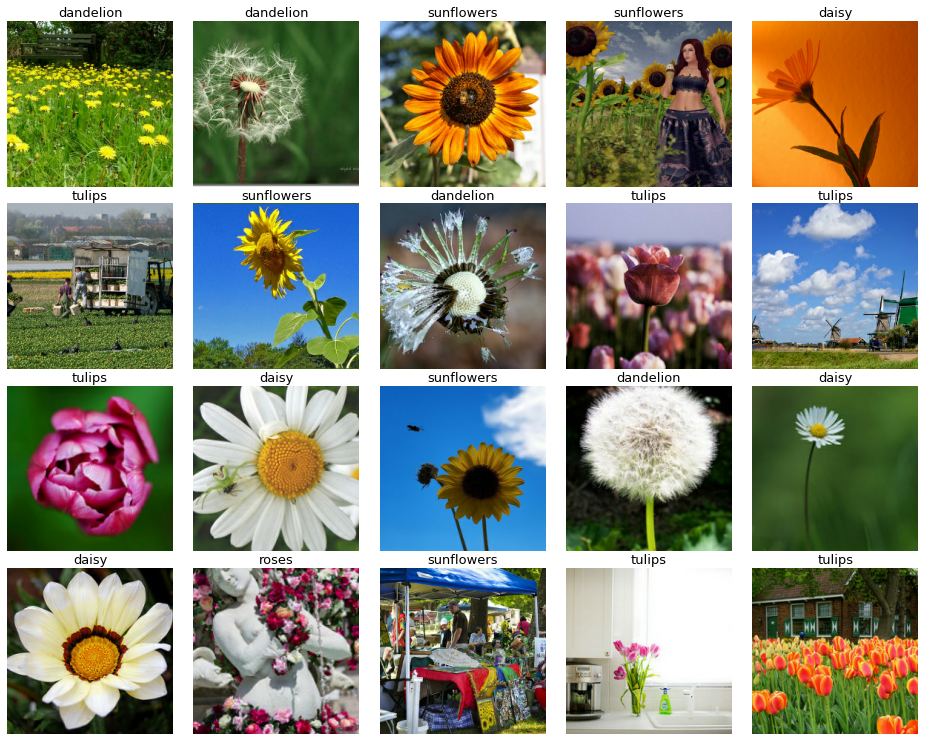

In [12]:
# 다음 이미지 세트를 위해 이 셀을 다시 실행
display_batch_of_images(next(train_batch))

# 모델

In [13]:
with strategy.scope():
    pretrained_model = tf.keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=[*IMAGE_SIZE, 3])
    
    pretrained_model.trainable = True  # 파인 튜닝
    
    model = tf.keras.Sequential([
        tf.keras.layers.Lambda(  # 이미지 형식을 int[0,255]에서 이 모델이 예상하는 형식으로 변환
            lambda data: tf.keras.applications.mobilenet.preprocess_input(
                tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(16, activation='relu', name='flower_dense'),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax', name='flower_prob')
    ])
    
    mult = 0.4  # 사전 훈련된 레이어의 경우
    mult_by_layer={ 
            # 분류 헤드
            'flower_prob': 1.0,
            'flower_dense': 1.0,
            # 사전 훈련된 레이어
            'block_1_': 0.02 * mult,
            'block_2_': 0.04 * mult,
            'block_3_': 0.06 * mult,
            'block_4_': 0.08 * mult,
            'block_5_': 0.1 * mult,
            'block_6_': 0.15 * mult,
            'block_7_': 0.2 * mult,
            'block_8_': 0.25 * mult,
            'block_9_': 0.3 * mult,
            'block_10_': 0.35 * mult,
            'block_11_': 0.4 * mult,
            'block_12_': 0.5 * mult,
            'block_13_': 0.6 * mult,
            'block_14_': 0.7 * mult,
            'block_15_': 0.8 * mult,
            'block_16_': 0.9 * mult,
            # 이 레이어들은 tf.keras.applications.MobileNetV2에 안정적인 식별자가 없음
            'conv': 0.5 * mult,
            'Conv': 0.5 * mult
    }
        
    # (옮긴이가 수정)
    #optimizer = AdamW(lr=LR_MAX, model=model, lr_multipliers=mult_by_layer)
    optimizer = tf.keras.optimizers.experimental.AdamW()

model.compile(
    #optimizer='adam',
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    steps_per_execution=8
)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flower_dense (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 2,244,453
Non-

# 훈련

In [14]:
history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
                    callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/13
373/373 [==============================] - 674s 2s/step - loss: 1.2112 - sparse_categorical_accuracy: 0.5359 - val_loss: 1.1114 - val_sparse_categorical_accuracy: 0.5824 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4e-05.
Epoch 2/13
373/373 [==============================] - 619s 2s/step - loss: 0.5599 - sparse_categorical_accuracy: 0.8100 - val_loss: 0.4091 - val_sparse_categorical_accuracy: 0.8588 - lr: 4.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 7.000000000000001e-05.
Epoch 3/13
373/373 [==============================] - 604s 2s/step - loss: 0.3351 - sparse_categorical_accuracy: 0.8840 - val_loss: 0.2458 - val_sparse_categorical_accuracy: 0.9103 - lr: 7.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/13
373/373 [==============================] - 609s 2s/step - loss: 0.2694 - sparse_categorical_accuracy: 0.9032 - val_loss: 0

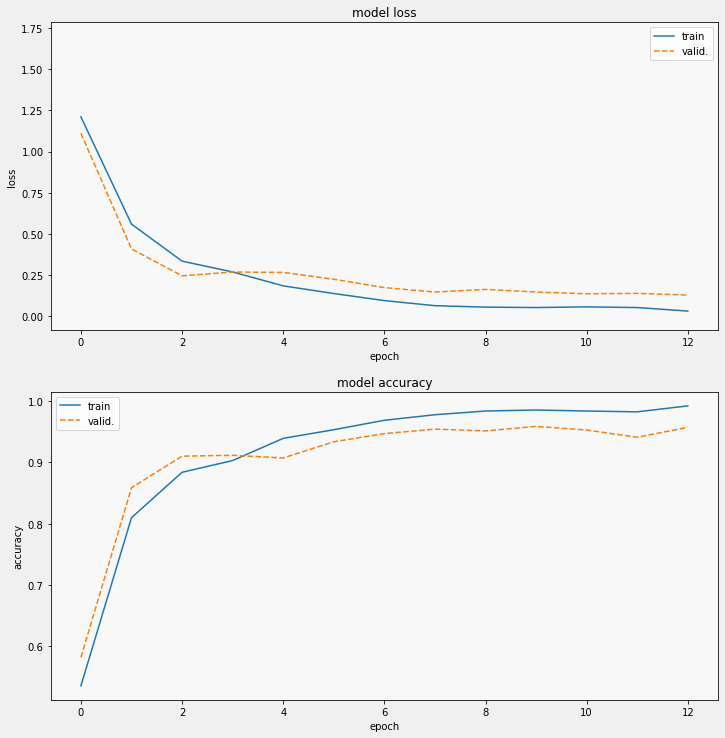

In [15]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211, ylim=[0,1.7])
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)


# 혼동 행렬

In [16]:
cmdataset = get_validation_dataset(ordered=True)  # 데이터셋을 분할하고 이미지와 레이블을 개별적으로 반복하므로 순서가 중요
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()  # 모든 것을 하나의 배치로 가져오기
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


85/85 [==============================] - 33s 390ms/step
Correct   labels:  (680,) [1 4 0 ... 0 2 0]
Predicted labels:  (680,) [1 4 0 ... 0 2 0]


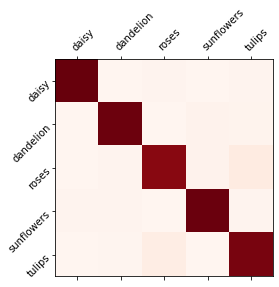

f1 score: 0.958, precision: 0.958, recall: 0.958


In [18]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T  # 정규화됨
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# 시각적 평가

In [19]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

1/1 [==============================] - 1s 683ms/step


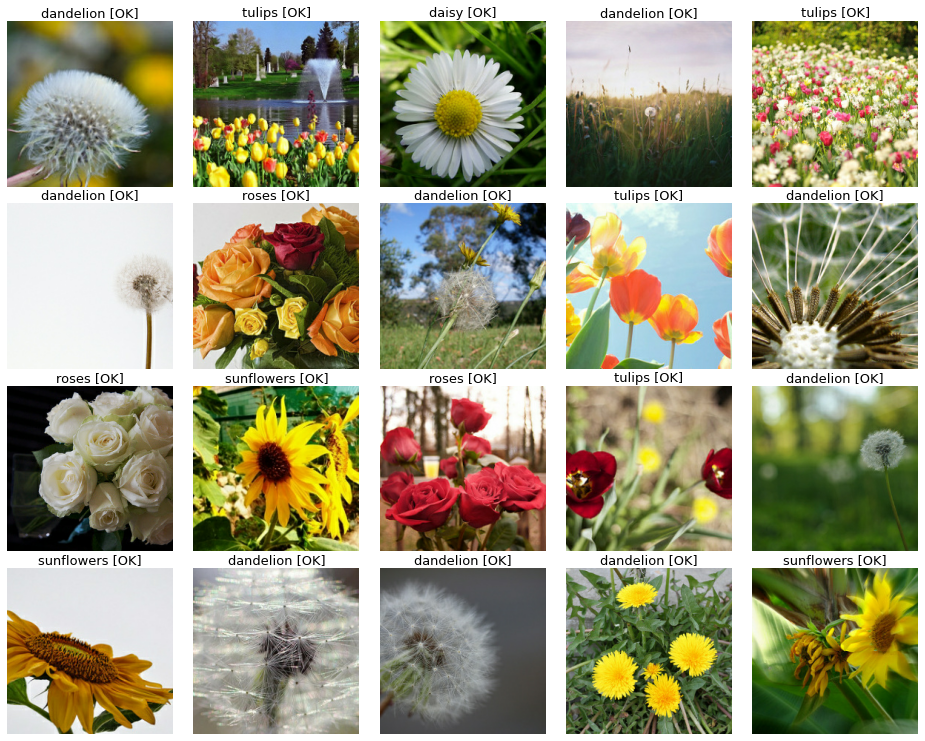

In [20]:
# 다음 이미지셋을 위해 이 셀을 다시 실행
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

## 라이선스
Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.